### Predicting aqueous solubility of organic compounds.

In this tutorial we are gonig to use linear regression for predicting solubility of organic compounds. I have combined two data sets into one which contains smiles and experimental solubilities of 1640 compounds ([download]()). Original data sets can be found [here](http://ftp.ics.uci.edu/pub/baldig/learning/Delaney/) and [here](http://ftp.ics.uci.edu/pub/baldig/learning/Huuskonen/source/). 

#### References
*John S. Delaney, J. Chem. Inf. Comput. Sci., 2004, 44, 1000 - 1005.*    
*Jarmo Huuskonen, J. Chem. Inf. Comput. Sci., 2000, 40, 773-777.*

###  Features extractions using [RDKIT](http://www.rdkit.org/)

In [ ]:
import time, csv
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors

def get_smiles_sol(file_name):
    '''
    Return smiles and experimental solubiliy for each molecule
    '''    
    with open(file_name, 'rb') as f:
        csv_reader = csv.reader(f, delimiter = ',')
        csv_reader.next()
        data = [(row[0],float(row[1])) for row in csv_reader]
    
    return data

def extract_descr(data):
    '''
    Return a list of descriptors for each smiles string
    '''  
    list_of_descr = []
    for mol in data:         
        m = Chem.MolFromSmiles(mol[0])
        calc = MoleculeDescriptors.MolecularDescriptorCalculator(descr_names)
        each_mol = [i for i in calc.CalcDescriptors(m)]  
        each_mol.append(mol[0])
        each_mol.append(mol[1])
        list_of_descr.append(each_mol)
    
    return list_of_descr

# Getting descriptors names
descr_names = [i[0] for i in Descriptors._descList]

descriptors = extract_descr(get_smiles_sol('combined_solubility.csv'))

# Appending 'smiles' and 'sol' to the descriptors names
descr_names.append('smiles')
descr_names.append('sol')

In [ ]:
# Writing data to .csv files
def write_to_csv(file_name, data):
    with open(file_name, 'wb') as f:
        csv_writer = csv.writer(f, delimiter = ',')
        csv_writer.writerow(descr_names)
        csv_writer.writerows(data)

write_to_csv('rdkit_descr_solubility.csv', descriptors)

Training and testing files with descriptors can be found [here](https://www.dropbox.com/s/z88nhlfllmeajjk/rdkit_train_sol.csv?dl=0) and [here](https://www.dropbox.com/s/8d23sjuizhbuqqe/rdkit_test_sol.csv?dl=0)

### Building the model.

In [1]:
# Importing required libraries

%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Loading data into Pandas data frame

train_data = pd.read_csv('rdkit_train_sol.csv')
test_data = pd.read_csv('rdkit_test_sol.csv')

# X -> fetures, y -> experimental solubility
X_train = train_data[train_data.columns[:-1]]
y_train = train_data.sol

X_test = test_data[test_data.columns[:-1]]
y_test = test_data.sol

In [3]:
# Importing a linear model and r2_score
from sklearn import linear_model
from sklearn.metrics import r2_score

model = linear_model.LinearRegression()

# Training the model

model.fit(X_train, y_train)

# Getting a list of predicted solubility(y_pred)

y_pred = model.predict(X_test)

# Getting the r2 score (performance) of our model

score = r2_score(y_test, y_pred)

print 'R2 = {}'.format(round(score, 4))

R2 = 0.915


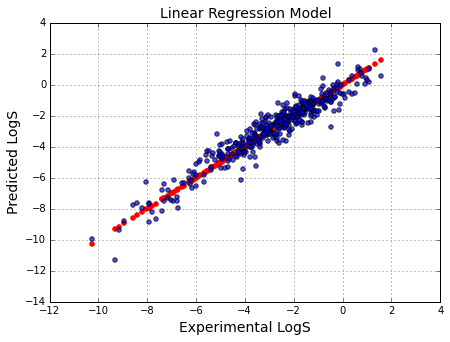

In [4]:
# Setting a figure size
plt.rcParams['figure.figsize'] = (7.0, 5.0)

# Plotting the results

# experimental LogS
plt.scatter(y_test, y_test, color = 'red')
# predicted LogS
plt.scatter(y_test, y_pred, alpha = 0.7)
plt.grid(1)
plt.title('Linear Regression Model', fontsize = 14)
plt.xlabel('Experimental LogS', fontsize = 14)
plt.ylabel('Predicted LogS', fontsize = 14)

Let's try to use a variation of a Linear Refression ([Lasso](http://scikit-learn.org/stable/modules/linear_model.html#lasso)) to see if we can get a better score.

In [7]:
lasso = linear_model.Lasso(alpha = 0.0001, max_iter=100000)

lasso.fit(X_test, y_test)

y_lasso = lasso.predict(X_test)

score = r2_score(y_test, y_lasso)

print 'R2 = {}'.format(round(score, 4))

R2 = 0.9619


The Lasso model runs a little slower but gives a better result.

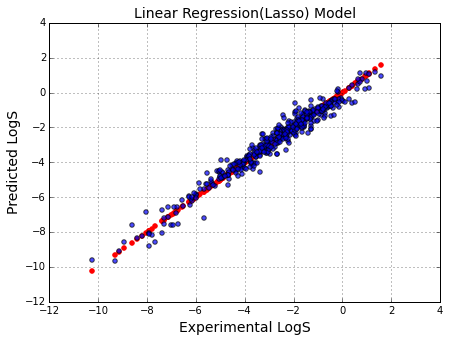

In [8]:
# Setting a figure size
plt.rcParams['figure.figsize'] = (7.0, 5.0)

# Plotting the results

# experimental LogS
plt.scatter(y_test, y_test, color = 'red')
# predicted LogS
plt.scatter(y_test, y_lasso, alpha = 0.7)
plt.grid(1)
plt.title('Linear Regression(Lasso) Model', fontsize = 14)
plt.xlabel('Experimental LogS', fontsize = 14)
plt.ylabel('Predicted LogS', fontsize = 14)

In [9]:
# Building a very simple user interface

from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors

class PredictSol(object):
    '''
    Provide a user interface for predicting of aqueous solubility of organic compounds.
    Input -> smiles string, model. Output -> solubility(LogS)
    '''
    def __init__(self, smiles, model):
        self.smiles = smiles
        self.model = model
                
    def predict(self):
        descr_names = [i[0] for i in Descriptors._descList if i[0] != 'ExactMolWt']
        m = Chem.MolFromSmiles(self.smiles)
        calc = MoleculeDescriptors.MolecularDescriptorCalculator(descr_names)
        descr = [i for i in calc.CalcDescriptors(m)]  
        self.pred_sol = self.model.predict(descr)
        print 'Predicted solubility is: {:.2f}'.format(self.pred_sol[0])        
    

In [10]:
s = PredictSol('Cc1cc2ccccc2cc1C', lasso)
s.predict()


Predicted solubility is: -4.57
